# How to integrate Financial Data from Refinitiv Data Platform to Excel with Xlwings - Part 1

## Overview

With the rise of Data Scientists, Financial coders or Traders (aka Citizen Developers), and the rapid growth of [Jupyter](https://jupyter.org/) application, the main target of every Citizen Developer is replacing [Microsoft Excel](https://www.microsoft.com/en-us/microsoft-365/excel) with the Jupyter application (reference: [Jupyter is the new Excel](https://towardsdatascience.com/jupyter-is-the-new-excel-a7a22f2fc13a)).

However, Excel is not obsolete and is still an important file-format/application for businesses. It is easy to distribute, and non-IT people (especially your boss) can open it easily rather than having to set up the Jupyter/Python environment.

This article is the first part of the series that demonstrate how to export financial data and report from Python/Jupyter application to Excel report file using xlwings CE and xlwings Pro libraries. The demo application uses content from [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis) via the ease-of-use [Data Library for Python](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python) as an example of  a dataset.

## Introduction to xlwings

[xlwings](https://www.xlwings.org) is a Python library that makes it easy to call Python from Excel and vice versa on Windows and macOS. The library lets you automate Excel from Python source code to produce reports or to interact with Jupyter notebook applications. It also allows you to replace VBA macros with Python Code or write UDFs (user defined functions - Windows only).
* The [xlwings CE](https://docs.xlwings.org/en/stable) is a free and open-source library ([BSD-licensed](https://opensource.org/licenses/BSD-3-Clause)) which provides basic functionalities to lets developers integrate Python with Excel. 
* The [xlwings PRO](https://docs.xlwings.org/en/latest/pro/license_key.html) provides more advance features such as [reports](https://www.xlwings.org/reporting), embedded Python code in Excel, one-click installers for easy deployment, video training, dedicated support and much more. 
 

*Note*:
- This notebook is based on xlwings versions **0.30.12**.

## Introduction to the Data Library for Python

The Refinitiv Data Library for Python provides a set of ease-of-use interfaces offering coders uniform access to the breadth and depth of financial data and services available on the Refinitiv Data Platform. The API is designed to provide consistent access through multiple access channels and target both Professional Developers and Financial Coders. Developers can choose to access content from the desktop, through their deployed streaming services, or directly to the cloud. With the Refinitiv Data Library, the same Python code can be used to retrieve data regardless of which access point you choose to connect to the platform.

![Figure-1](images/rdlib_image.png "Data Library Diagram") 

The RDP Library are available in the following programming languages:
- [Python](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python)
- [TypeScript/JavaScript](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-typescript)
- [.NET](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for--net)

For more deep detail regarding the RDP Libraries, please refer to the following articles and tutorials:
- [Quickstart](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/quick-start).
- [Documentation](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/documentation).
- [Tutorials](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/tutorials).
- [GitHub](https://github.com/LSEG-API-Samples/Example.DataLibrary.Python).

### Disclaimer

As this notebook is based on RD Library Python versions **1.5.0**.

## Code Walkthrough

Let start with xlwings CE first. The application needs to import ```xlwings``` and ```refinitiv.data``` packages in order to interact with xlwings CE and RD library.

In [2]:
# import xlwings and RD library
import xlwings as xw
import refinitiv.data as rd

Next,set the App Key credentials and import other required libraries

In [3]:
import os
import sys
from dotenv import dotenv_values
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tick
import json
config = dotenv_values(".env")


appkey = config['WS_APP_KEY']

The next step is to open a session defined in a custom configuration file.

This Jupyter Notebook is focusing on the *DesktopSession* only. However, the main logic for other session types are the same when interacts with xlwings library.

In [4]:
rd.open_session(config_name='./refinitiv-data.dev.config.json')

<refinitiv.data.session.Definition object at 0x216ca38cd90 {name='workspace'}>

Firstly, we will use RD Library to request time-series data as a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object. 

In [5]:
# Declare parameter(s)
universe = 'LSEG.L'
historical_title = '%s Historical Data' % (universe)

In [6]:
df_historical = rd.get_history(
    universe=[universe], 
    fields=['BID','ASK','OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1','NUM_MOVES'], 
    interval='1D',
    count = 90
)
df_historical

LSEG.L,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
Date,,,,,,,
2023-07-12,7986,7988,8024,8078,7976,8034.0,4046
2023-07-13,8092,8094,8018,8108,7970,7987.66663,3731
2023-07-14,8288,8290,8070,8318,8070,8070.0,3862
2023-07-17,8300,8302,8250,8322,8236,8296.0,2033
2023-07-18,8306,8308,8344,8344,8266,8308.0,3379
...,...,...,...,...,...,...,...
2023-11-09,8534,8536,8510,8588,8510,8510.0,4114
2023-11-10,8554,8556,8536,8578,8514,8544.6723,2932
2023-11-13,8446,8448,8578,8588,8416,8461.75,5490


### Interact with xlwings CE

With xlwings, we can export this ```df_historical``` DataFrame to excel directly.

The first step is initiate xlwings object and establish a connection to a workbook.

In [7]:
wb = xw.Book() # Creating an new excel file. wb = xw.Book(filename) would open an existing file

The above step initiates xlwings workbook class in ```wb``` object. The ```wb = xw.Book()``` statement creates a new excel file. If you are using ```wb = xw.Book(filename)```, the xlwings will open an existing file.

![Figure-2](images/report_1.png "create a blank excel workbook") 

Next, instantiate the xlwings [sheet object](https://docs.xlwings.org/en/stable/api.html#sheet). The application will interact with Excel file mostly via this sheet object.

In [8]:
# Select the first excel sheet, and rename it

historical_sheet = wb.sheets[0]
historical_sheet.name = historical_title

![Figure-3](images/report_2_rename_sheet.png "rename workbook") 

Then you can just pass your dataframe object to ```sheet.range(<cell>).value``` property to set Pandas DataFrame to Excel directly.

In [9]:
# Set historical_sheet dataframe to cell A1

historical_sheet.range("A1").value = df_historical.head(30)

![Figure-4](images/report_3_dataframe.png "add data as is") 

That is, the application is ready to get and export Refinitiv Data to an Excel file.

The above example shows how to export data "as is" which often hard to read. The application can use xlwings API to customize excel report look and feel, and then customize Pandas DataFrame to make data easier to understand.

In [10]:
# Clear current sheet
historical_sheet.clear()

Then we use xlwings ```Sheet``` object and its ```api``` property to change report look and feel.

*Note*:
The xlwings ```api``` property supports Windows only. For MacOS, please refer to [this page](https://docs.xlwings.org/en/stable/missing_features.html).

In [11]:
historical_sheet.range("A1").value = historical_title
historical_sheet.range("A1").api.Font.Size = 14 # Change font size
historical_sheet.range("A1").api.Font.ColorIndex = 2 # Change font color
historical_sheet.range('A1:H1').color = (0,0,255) # Change cell background color

The above statements create the following excel  report look and feel.

![Figure-5](images/report_4.png "set title and header") 

We can restructure the ```df_historical``` DataFrame to make it easier to read by naming the index column to "Date"

In [12]:
df_historical.index.name = 'Date'
df_historical.head(5)

LSEG.L,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
Date,,,,,,,
2023-07-12,7986,7988,8024,8078,7976,8034.0,4046
2023-07-13,8092,8094,8018,8108,7970,7987.66663,3731
2023-07-14,8288,8290,8070,8318,8070,8070.0,3862
2023-07-17,8300,8302,8250,8322,8236,8296.0,2033
2023-07-18,8306,8308,8344,8344,8266,8308.0,3379


Next, we set the DataFrame object to *A2* cell, then set column header font and background color to make them distinguish from data.

In [13]:
historical_sheet.range("A2").value = df_historical.head(30)

#Make Column headers bold
historical_sheet.range('2:1').api.Font.Bold = True
# Change cell background color
historical_sheet.range('A2:H2').color = (144,238,144) 
# Set sheet autofit the width of row
historical_sheet.autofit('r')

The result is the following readable report table:

![Figure-6](images/report_5.png "workbook with format") 

## Plotting a Graph

The xlwings CE also supports [Matplotlib](https://matplotlib.org/) figures in Excel as a picture.

Firstly, we change all non-Date columns data type from String to Float.

In [14]:
for column in df_historical:
    df_historical[column]=df_historical[column].astype(float)

 we change the DataFrame Date index to be a data column. This will let us plot a graph using **Date** as X-Axis.

In [15]:
df_historical.reset_index(level=0, inplace=True)
df_historical.head(5)

LSEG.L,Date,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
0,2023-07-12,7986.0,7988.0,8024.0,8078.0,7976.0,8034.00000,4046.0
1,2023-07-13,8092.0,8094.0,8018.0,8108.0,7970.0,7987.66663,3731.0
2,2023-07-14,8288.0,8290.0,8070.0,8318.0,8070.0,8070.00000,3862.0
3,2023-07-17,8300.0,8302.0,8250.0,8322.0,8236.0,8296.00000,2033.0
4,2023-07-18,8306.0,8308.0,8344.0,8344.0,8266.0,8308.00000,3379.0


Then sort data as ascending order.

In [16]:
# Sort DataFrame by Date
df_historical.sort_values('Date',ascending=True,inplace=True)

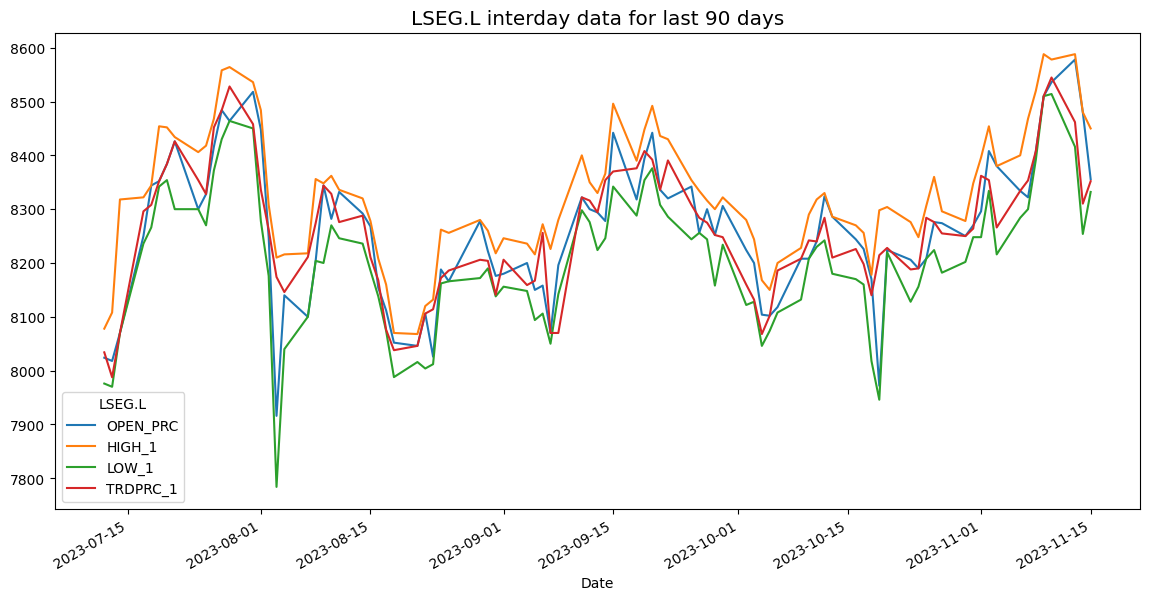

In [17]:
# Plotting a Graph

columns = ['OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1']

df_historical.set_index('Date',drop=True,inplace=True)
fig = plt.figure()


plt.ticklabel_format(style = 'plain')
plt.title(f'{universe} interday data for last 90 days', color='black',fontsize='x-large')
ax = fig.gca()


df_historical.plot(kind='line', ax = fig.gca(),y=columns,figsize=(14,7) )
plt.show()

We will put this graph at the end of the report table in the Excel sheet. The application can check the position of the last row of the report table with xlwings [end()](https://docs.xlwings.org/en/0.20.5/api.html#xlwings.Range.end) function.

- The ```sheet.cells.last_cell``` statement returns lower right cell
- The ```sheet.cells.last_cell.row``` statement returns row of the lower right cell

In [18]:
# historical_sheet.cells.last_cell.row = row of the lower right cell

'''
change to your specified column, then go up until you hit a non-empty cell
'''
historical_last_row = historical_sheet.range((historical_sheet.cells.last_cell.row, 1)).end('up').row  
historical_last_row

#historical_last_row = historical_sheet.range('A' + str(historical_sheet.cells.last_cell.row)).end('up').row

32

Then, gets the position of the *last row of the table + 3 rows* cell. This makes a space between the data table and graph.

In [19]:
rng = historical_sheet.range('B{row}'.format(row = historical_last_row + 3))
rng

<Range [Book1]LSEG.L Historical Data!$B$35>

Next, we add this figures as a picture to the xlwings CE sheet object with [pictures API](https://docs.xlwings.org/en/0.20.5/api.html#pictures).

In [20]:
historical_sheet.pictures.add(fig, name='MyPlot', update=True, top=rng.top, left=rng.left)

<Picture 'MyPlot' in <Sheet [Book1]LSEG.L Historical Data>>

The result is the following readable report table:

![Figure-7](images/report_6.png "graph is ready") 

## Adding new Excel Sheet

We can create a new excel sheet and export data from RDP to that newly created sheet dynamically.

In [21]:
news_sheet_title = '%s News Data' % (universe)
# Create new sheet for News Data
wb.sheets.add(news_sheet_title)  

<Sheet [Book1]LSEG.L News Data>

The above xlwings statement creates a new sheet in your excel workbook. 

![Figure-8](images/report_7.png "create new sheet") 

Then you can get this newly created sheet object and export data to it. I will demonstrate with News data.

In [22]:
# -- Requesting News Data

from datetime import timedelta
news_df = rd.news.get_headlines(universe, start="20.03.2021", end=timedelta(days=-10), count=10)
news_df.head(3)

,headline,storyId,sourceCode
versionCreated,,,
2023-11-06 12:37:08.004,"London Stock Exchange Group (LSEG: GBX8,300.0)...",urn:newsml:newsroom:20231106:nNRAql52rd:0,NS:GLOTRA
2023-11-06 12:27:01.178,"London Stock Exchange Group (LSEG: GBX8,300.0)...",urn:newsml:newsroom:20231106:nNRAql4ydh:0,NS:GLOTRA
2023-11-06 12:26:41.534,"London Stock Exchange Group (LSEG: GBX8,300.0)...",urn:newsml:newsroom:20231106:nNRAql4y8h:0,NS:GLOSTO


In [23]:
# initiate the xlwings sheet object]
news_sheet = wb.sheets[news_sheet_title]

#Set Sheet Title
news_sheet.range("A1").value = f'{universe} News data'
news_sheet.range("A1").api.Font.Size = 14 # Change font size
news_sheet.range("A1").api.Font.ColorIndex = 2 # Change font color
news_sheet.range('A1:U1').color = (0,0,255) # Change cell background color

The result is following:

![Figure-9](images/report_8.png "set NEws sheet header") 

Then we export DataFrame ```news_df``` object to News sheet ```news_sheet``` object.

In [24]:
news_sheet.range("A2").options(index=False).value = news_df

news_sheet.range('2:1').api.Font.Bold = True
news_sheet.range('A2:U2').color = (144,238,144) # Change cell background color

![Figure-10](images/report_9.png "set ESG report data") 

Then we save this excel file with xlwings ```Book``` object ```save()``` function.

In [25]:
wb.save('rdp_report.xlsx') # Classic Jupyter Notebook

# wb.save() # Note: Somehow the Jupyter Lab is not allow overriden file as Classic Notebook.

## Reporting with xlwings PRO

The above example source code shows that you can create an excel report file from Refinitiv Data easily with xlwings CE API. However, the Python application source code is a combination of formatting the report's look & feel and handling the data which makes the source code difficult to maintain in the long run.

The [xlwings PRO ](https://www.xlwings.org/pro) has features to solve all of CE version limitations. The [xlwings Reports](https://www.xlwings.org/reporting) provides a capability to generate excel report file with the following features:
- **Separation of code and design**: Users without coding skills can change the template on their own without having to touch the Python code.
- **Template variables**: Python variables (between curly braces) can be directly used in cells, e.g. ```{{ title }}```. They act as placeholders that will be replaced by the actual values.
- **Frames for dynamic tables**: Frames are vertical containers that dynamically align and style tables that have a variable number of rows.

You can get a free trial for xlwings PRO [here](https://docs.xlwings.org/en/latest/pro/license_key.html), then follow the instruction on [How to activate xlwings PRO](https://docs.xlwings.org/en/stable/installation.html#how-to-activate-xlwings-pro) page.



Now let import the report package from xlwings PRO.

In [26]:
# #uncomment if you do not already install xlwings PRO package.

# #Install xlwings PRO packages in a current Jupyter kernal
#import sys
#!{sys.executable} -m pip install "xlwings[all]"

In [27]:
from xlwings.pro.reports import create_report

ImportError: You are using a legacy xlwings license key that requires the 'cryptography' package. Either install it via 'pip install cryptography' or contact us for a new license key that doesn't depend on cryptography.